# TP Analyse de l'enrichissement en pathway Gene Ontology


## Jeux de données
* Experimental dataset as TSV
* Go ontology as [owl](http://www.obofoundry.org/ontology/go.html)
* Uniprot entries as XML files

### Manipulation de l'ontologie
* Annotation des protéines
* API de l'objet arbre

### Construction de l'analyse d'enrichissement en termes GO
* **Questions:**
    * Les protéines très abondantes présentent-elles des termes GO en quantité remarquable ?
    * Les protéines peu abondantes présentent-elles des termes GO en quantité remarquable ?


1. Découverte de la modélisation hypergéometrique des fréquences attendues des termes GO
2. Implémentation du test d'enrichissement d'un terme GO
3. Application du test à l'arbre des termes GO
4. Affichage **riche** des resultats du test dans le notebook

    
    
## Ressources
https://www.bioconductor.org/help/course-materials/2015/SeattleApr2015/E_GeneSetEnrichment.html
    
## Pour aller plus loin (TP5)
Visualisation de l'arbre des termes GO avec représentation des protéines et pValue d'enrichissement

## Remarque
Pour faciliter le développement nous considerereons comme **S**ur**A**bondante toute protéine à **Log2 Corrected Abundance Ratio** supérieur à 0.

##### IFB Virtual Machine Configuration

* `rootDir` points to Jupyter Home Directory
* `projectDir` points to the Git project, holds the *tsv* file
* `libDir` points to Git project python library with files names `go.py  stat_utils.py  uniprot.py`
* `dataDir` points to shared data folder with uniprot and GO files

In [1]:
import sys

rootDir = "//ifb/data/mydatalocal"
projectDir = rootDir + "/VDB_jupyter"
libDir = projectDir + "/lib"
dataDir= "/ifb/data/public/teachdata/m2binf_ucbl/data" 

sys.path.append(libDir)

In [2]:
import pandas, uniprot, go
import numpy as np
from stat_utils import computeORA_BKG

In [3]:
%matplotlib nbagg
import matplotlib.pyplot as plt

## Lecture des données d'abondance

### Format des données expérimentales

Le terme *SA*, désigne le ratio de (**S**ur) **A**bondance pour une protéines entre deux experiences.
Les valeurs de **SA** sont stockées dans la colonne ```Log2 Corrected Abundance Ratio```. Un "ratio" négatif indique qu'une protéine est moins présente dans l'experience considéré par rapport à une experience de référence.

* La condition experimentale de référence est un milieu de croissance bactérienne
* La condition experimentale testée est un milieu riche en Tétracycline 



### Lecture des valeurs experimentales
Charger ```TCL_wt1.tsv``` dans une [dataframe pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html).
* Retirer les lignes présentant des aberrations numériques
* Créer une DataFrame ne contenant que les lignes où **Log2 Corrected Abundance Ratio** > 0

In [4]:
import pandas
df=pandas.read_csv(projectDir + "/TCL_wt1.tsv", delimiter ="\t")
df.head()

,Accession,Description,Gene Symbol,Corrected Abundance ratio (1.53),Log2 Corrected Abundance Ratio,Abundance Ratio Adj. P-Value: (127. T3 Tc WT) / (126. T0 WT),LOG10 Adj.P-val
0,P75936,Basal-body rod modification protein FlgD OS=Es...,flgD,0.075816993,-3.721334942,0.000055,4.260067469
1,P76231,Uncharacterized protein YeaC OS=Escherichia co...,yeaC,0.092810458,-3.429568818,0.000351,3.45462743
2,P0A8S9,Flagellar transcriptional regulator FlhD OS=Es...,flhD,0.102614379,-3.284695189,0.000027,4.571899347
3,P0CE48,Elongation factor Tu 2 OS=Escherichia coli (st...,tufB,#VALEUR!,#VALEUR!,NaN,#VALEUR!
4,P05706,PTS system glucitol/sorbitol-specific EIIA com...,srlB,0.108496732,-3.204276506,0.019963,1.699767669


In [5]:
dfClean = df[ (df['Log2 Corrected Abundance Ratio'] != '#VALEUR!') & (df['LOG10 Adj.P-val'] != '#VALEUR!')]
dfClean = dfClean.copy()
dfClean.loc[:,'Log2 Corrected Abundance Ratio'] = dfClean.loc[:,'Log2 Corrected Abundance Ratio'].astype(float)
dfClean.head()

,Accession,Description,Gene Symbol,Corrected Abundance ratio (1.53),Log2 Corrected Abundance Ratio,Abundance Ratio Adj. P-Value: (127. T3 Tc WT) / (126. T0 WT),LOG10 Adj.P-val
0,P75936,Basal-body rod modification protein FlgD OS=Es...,flgD,0.075816993,-3.721335,0.000055,4.260067469
1,P76231,Uncharacterized protein YeaC OS=Escherichia co...,yeaC,0.092810458,-3.429569,0.000351,3.45462743
2,P0A8S9,Flagellar transcriptional regulator FlhD OS=Es...,flhD,0.102614379,-3.284695,0.000027,4.571899347
4,P05706,PTS system glucitol/sorbitol-specific EIIA com...,srlB,0.108496732,-3.204277,0.019963,1.699767669
5,P29744,Flagellar hook-associated protein 3 OS=Escheri...,flgL,0.124183007,-3.009460,0.036746,1.434786589


# Definitions de pathway fonctionels: modèle statistique

Nous disposons d'un jeu de protéines caractérisées par

* Un ratio de quantification entre deux experiences
* Une fiche uniprot 

Par ailleurs, l'ontologie GO est disponible via
* un fichier plat de définition
* une librarie pour la manipuler

Il nous est demandé de detecter si certains termes GO sont fortement représentés parmi les protéines SurAbondantes.
Par la suite, on utilisera indifférement les termes **Pathway** et **annotation GO**.

### Evaluation théorique de l'abondance

* $Q+$ : Proteines Sur-représentées
* $\overline{Q+}$ : Proteines non Sur-représentées

* $PW^{a}$ : Nombre de protéines membres du Pathway$a$
* $\overline{PW^{a}}$ : Nombre de protéines non-membres du Pathway$a$



 Proteines | $Q+$  | $\overline{Q+}$ | Total lignes
 :--- | --- |--- |---|
membres de $PW^{a}$  | $PW^{a}_{Q+}$ | $PW^{a}_{\overline{Q+}}$ | $nPW^{a}$
non-membres de $PW_{a}$ | $\overline{PW^{a}}_{Q+}$ | $\overline{PW^{a}}_{\overline{Q+}}$ | $n\overline{PW^{a}}$
  **Total colonnes** | n$Q+$ | n$\overline{Q+}$ | **nTOT**
 
 
**Question**:"Le nombre de protéines sur-représentées dans le Pathway$a$ est-il grand comparé à ce qui serait attendu au hasard?"


<!--## Deprecated 
 **Question**:"Les protéines sur-représentées sont-elles plus fréquentes dans le Pathway$a$ que dans les protéines non-membre du Pathway$X$?"
 
L'hypothèse nulle est "Les protéines membres du pathway et non-membres du pathway ont des quantifications similaires".
 -->
        

### Modélisation du hasard par une loi hypergéométrique

Pour un pathway donné ($PWa$), chaque protéine sur-abondante peut être vue comme un tirage dans le pool de protéines de l'expérience. La population de ce pool est consituée de deux groupes:
 * Le groupe des protéines appartenant à $PWa$
 * Les autres ($\overline{PW^{a}}$)

La probabilité d'observer $k$ protéines de $PWa$ parmi les $n$ sur-abondantes se modélise alors naturellement par la loi de probabilité hypergéométrique.

Rappellez-vous,

Si X est la variable aléatoire du nombre de succès parmi n observations, sans remise.
Alors la probabilité d'oberver exactement $k$ succès, suit une loi hypergéométrique de paramètres $N, n$ et $k$

$P(X=k) = \frac{ {K\choose k} {N-K\choose n-k} } { {N\choose K} }$

où


* $K$ est le nombre de succès dans la population totale
* $n$ est le nombre d'observations
* $N$ est la taille de la population totale
* $k$ est le nombre de succès parmi les observations

Si **pour chaque $Pathway^{a}$**, $X$ est la variable aléatoire du **nombre de protéines sur-représentée** dans l'experience.


Cocher les relations correspondantes


  x  | $nTOT$ | $nPW^{a}_{Q+}$ | $nPW^{a}$ | $nQ+$
 --- | ---   | ---     | ---  | --- |
 $K$ |       |         |      | 
 $n$ |       |         |      | 
 $N$ |       |         |      | 
 $k$ |       |         |      | 
 
 
 
 
Rappel: $nPW^{a}_{Q+}$ est le nombre de protéines appartenant au $Pathway^{a}$ parmi les protéines surexprimées

Que représentent alors les deux expressions suivantes:

$ P(X=nPW^{a}_{Q+})= \frac{ {nPW^{a}\choose X} {n\overline{PW^{a}}\choose nQ^{+} - X} } { {nTOT\choose nPW^{a}} }$


$P(X >= PW^{a}_{Q+})  = \sum_{x_{i}=PW^{a}_{Q+}}^{x_{i} \le nQ+}\frac{ {nPW^{a}\choose x_{i}} {n\overline{PW^{a}}\choose nQ^{+} - x_{i}} } { {nTOT\choose nPW^{a}} }$


###### Créer la fonction qui retournera la probabilité, sous un [modèle hypergeométrique](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.hypergeom.html), d'obtenir $k$ succès ou plus,

```python
def righEnd_pValue(N, n, K, k) => p
```
Aux arguments:
* $N$, le nombre total d'objet
* $n$, le nombre de tirages
* $K$, le nombre total d'objet de *typeI*
* $k$, le nombre de tirage d'objet de *typeI* (ie: nombre de succès parmi les tirages)

##### Dessiner les lollipop charts de la densité de probabilité et de la densité cumulée de la loi

L'enrichissement en terme GO parmi les protéines surabondantes sera estimé par cette fonction, avec
* $N$, le nombre total de protéines annotées dans le protéome
* $n$, le nombre de protéines surabondantes
* $K$, le nombre de protéines annotées par ce terme GO dans le protéome
* $k$, le nombre de protéines annotées par ce terme GO dans les protéines surabondantes


*Exemple de figure à obtenir*
![caption](../figs/lollipop.png)


<IPython.core.display.Javascript object>


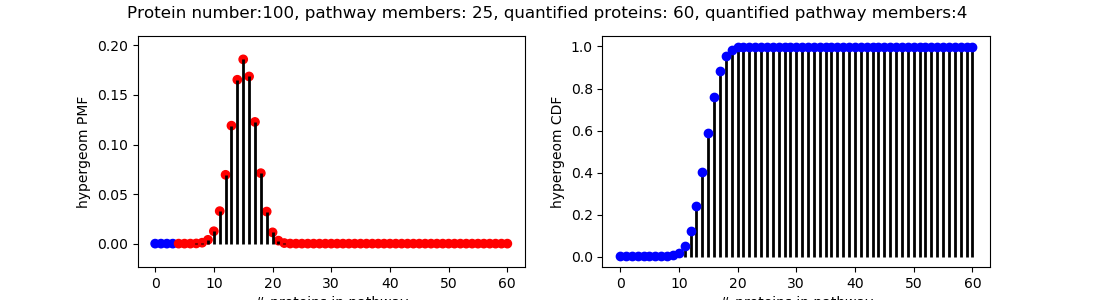

0.9999999833384777

In [18]:
from scipy.stats import hypergeom
saList = dfClean[ dfClean['Log2 Corrected Abundance Ratio'] > 0.0 ]['Accession'].tolist()

def righEnd_pValue(N, n, K, k):
    
    rv = hypergeom(N, K, n)
    x = np.arange(0, n+1)
    pmf_pathway_members = rv.pmf(x)
    cmf_pathway_members = rv.cdf(x)
    fig = plt.figure(figsize=(11, 3))
    ax = fig.add_subplot(121)
    ax.scatter(x, pmf_pathway_members, color = [ 'b' if _x < k else 'r' for _x in x ])
    ax.vlines(x, 0, pmf_pathway_members, lw=2)
    ax.set_xlabel('# proteins in pathway')
    ax.set_ylabel('hypergeom PMF')
    
    ax = fig.add_subplot(122)
    ax.plot(x, cmf_pathway_members, 'bo')
    ax.vlines(x, 0, cmf_pathway_members, lw=2)
    ax.set_xlabel('# proteins in pathway')
    ax.set_ylabel('hypergeom CDF')
    
    fig.suptitle(f"Protein number:{N}, pathway members: {K}, quantified proteins: {n}, quantified pathway members:{k} ")
    
    p_x = hypergeom(N, K, n).cdf([k - 1])
    return 1.00 - p_x[0]

righEnd_pValue(100, 60, 25, 4)

# Definitions de pathway fonctionels: manipulation de l'ontologie

## Ontologie
Les termes GO sont organisés en une structure hiérarchique ([DAG](https://en.wikipedia.org/wiki/Directed_acyclic_graph)). Dans ce type de graph les liens sont orientés, mais les noeuds fils peuvent avoir plusieurs parents.

Prenez un moment pour vous familliariser avec [sa structure](https://www.ebi.ac.uk/QuickGO/).

Les termes de cette ontologie sont organisés en trois arbres indépendants:
* **biological process**
* **molecular function**
* **cellular component**

On appellera **namespace** chacun de ces trois arbres. On travaillera séparement sur chaque namespace. Nous vous suggerons de commmencer à travailler sur le namespace **biological process**.

### Topologie des arbres de termes GO
Les noeuds sont des termes GO, auxquels nous allons associer des pValue d'enrichissement.

Les feuilles sont les protéines directement annotées par une terme GO.

###### Attention
Règle du vrai chemin: *Si une protéine est porteuse d'un terme GO, alors est elle aussi porteuse de tous les parents de ce terme.*
En d'autre terme la liste des protéines associées à un terme GO est l'ensemble des feuilles du sous arbre dont la racine est ce terme GO.

### Comment lire et manipuler une arbre de termes

######  Après le chargement initial de l'ontologie générique  
`go.setOntology(dataDir + "/go.owl")`

##### On créé  l'abre des termes GO membres d'un namespace et qui annotent  une liste de protéines
```python
goTreeObj = go.createGoTree(ns="biological process", proteinList=xpProtList, uniprotCollection=uniprotCollection)
```
Où
* `ns`, est le namespace GO étudié
* `proteinList`, une liste d'identifiants Uniprot
* `uniprotCollection`, une collection d'objet Uniprot



##### API de l'arbre d'annotations


###### Taille de l'abre
Affiche un tuple (feuilles, noeuds, protéines)
```python
goTreeObj.dimensions
```
#### Extraire un sous arbre
```python
sousArbre = goTreeObj.newRoot("transmembrane transport")
```

#### Enumerer les protéines porteuses de termes GO

##### Dans tout l'arbre
```python
proteinList = goTreeObj.getMembers()
```
##### A partir d'un noeud
```python
proteinList = goTreeObj.getMembersByName("transmembrane transport")
proteinList = goTreeObj.getMembersByID("GO:0055085")
```

#### Acceder directement à un noeud
```python
goTerm = goTreeObj.getByName("transmembrane transport")
goTerm = goTreeObj.getByID("GO:0055085")
```

#### Elager un arbre
On définit une fonction test (retournant vrai ou faux) à appliquer à chaque noeud de l'arbre de départ.
La fonction test recevra en argument le terme GO/objet noeud à analyser.
Si la fonction retourne faux pour un noeud, ce noeud et tous ses descendants seront éliminés dans l'arbre d'arrivée. 

**Exemple**: retirer tous les terme GO n'ayant aucune des protéines `'P75936', 'P76231', 'P0A8S9'` parmi leurs protéines annotées.
```python
def predicat(goTerm):
    return set(goTerm.getMembers()) & set(['P75936', 'P76231', 'P0A8S9'])

goTreeObj_avec_P75936_P76231_P0A8S9 = goTreeObj.drop(predicat)
```

### Chargements des données uniprot et GO génériques

In [13]:
uniprotCollection = uniprot.UniprotCollection(dataDir +"/dataset")
K12 = uniprot.UniprotCollection(dataDir + "/K12_proteome/")
xpProtList = dfClean['Accession'].tolist()
print("Loading ontology")
go.setOntology(dataDir + "/go.owl")

Loading ontology
Loaded


In [14]:
goTreeObj = go.createGoTree(ns="biological process", proteinList=xpProtList, uniprotCollection=uniprotCollection)

Extracting biological process ontology
Applying true path collapsing
2194 leaves, 3482 nodes, 1474 proteins


## Analyse de l'enrichissement en terme GO parmi les protéines surabondantes

### Récursivité de l'analyse d'enrichissement

**L'application de la fonction `righEnd_pValue` à chaque terme GO necessite le calcul des paramètres de la loi hypergéométrique:**
* **$N$** , le nombre total de protéines annotées dans le protéome $\Longleftrightarrow$ nombre de feuilles dans l'arbre GO du protéome
* **$n$**, le nombre de protéines surabondantes $\Longleftrightarrow$ nombre de feuilles/protéines surabondante dans l'arbre des protéines experimentales 
* **$K$**, le nombre de protéines annotées par ce terme GO dans le protéome $\Longleftrightarrow$ nombre de feuilles dans le sous arbre de ce terme GO issu de l'arbre GO du protéome
* **$k$**, le nombre de protéines annotées par ce terme GO dans les protéines surabondantes $\Longleftrightarrow$ nombre de feuilles dans le sous arbre de ce terme GO issu de l'arbre GO des protéines expérimentales


##### Ensembles  de protéines
Le calcul des paramètres de chaque terme GO et de la p-value d'enrichissement nécessite donc deux ensembles (listes) de protéines différents:

* Les protéines quantifiées dans l'experience: `xpProtList = dfClean['Accession'].tolist()`
* [Le protéome](https://www.uniprot.org/proteomes/UP000000625) de la bactérie étudiée: `K12 = uniprot.UniprotCollection(dataDir + "/K12_proteome/")`


On a donc choisi le protéome pour définir à chaque terme GO les paramètres $K$ et $N$ du modèle hypergéométrique. 
* Que pensez-vous de ce choix ?
* Quelles seraient les alternatives?

### Application aux protéines étudiées


##### Nous allons donc devoir travailler avec deux arbres d'ontologie GO
Ces arbres diffèrent par leurs noeuds (les termes) et leurs feuilles (les protéines). Pour les besoins de l'exemple nous étudierons le namespace **biological process**.

##### Permier arbre: l'arbre des termes des protéines mesurées dans l'expérience
`xpGoTree_BP = go.createGoTree(ns="biological process", proteinList=xpProtList, uniprotCollection=uniprotCollection)`

Où `xpProtList` est la liste des identifiants Uniprot des protéines expérimentales et `uniprotCollection` une collection d'objets Uniprot précédemment créée.

######  Deuxieme arbre : l'arbre des termes de toutes les protéines de l'organisme étudié
`fullEcoliGoTree_BP = go.createGoTree(ns="biological process", proteinList=K12.list, uniprotCollection=K12)`

Où `K12.list` est la liste des identifiants uniprot du protéome de *E.Coli* et `K12`  une collection d'objets Uniprot précédemment créée.

In [16]:
goTreeObjExp = go.createGoTree(ns="biological process", proteinList=xpProtList, uniprotCollection=uniprotCollection)
goTreeObjRef = go.createGoTree(ns="biological process", proteinList=K12.list, uniprotCollection=K12)

Extracting biological process ontology
Applying true path collapsing
2194 leaves, 3482 nodes, 1474 proteins
Extracting biological process ontology
Applying true path collapsing
2728 leaves, 6650 nodes, 3128 proteins


### Calculons la pValue du terme "transmembrane transport"
*Quelle est la probabilité d'observer au moins ce nombre de protéines annotées "transmembrane transport" parmi les protéines surabondantes?*
#### Determinations des paramètres de la loi hypergéométrique

##### 1° Extraire la liste des protéines avec *'Log2 Corrected Abundance Ratio'* > 0.0
Ce sera notre liste de protéines sur-abondantes $\Rightarrow n$

##### 2° Extraire la liste des protéines de E.Coli annotées dans l'arbre GO "protéome total"
Ce sera notre liste de totale de protéines $\Rightarrow N$

##### 3° Extraire la liste des protéines "transmembrane transport"
* Dans l'arbre GO "protéome total" $\Rightarrow K$
* Dans l'arbre GO "expérimental" **ET** surabondates $\Rightarrow k$

##### 4° Appeller la fonction righEnd_pValue
A l'aide des paramètres précedents calculer *la probabilité d'observer au moins $k$ protéines annotées "transmembrane transport" parmi les protéines surabondantes*

*Exemple de figure à obtenir* 
![caption](../figs/TM_pvalue.png)

La pvalue d'enrichissement du terme "transmembrane transport" est de 0.381

0.38143716334525035

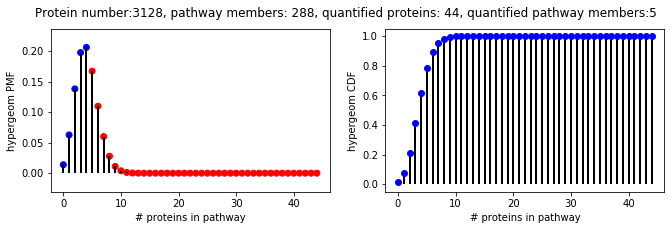

In [26]:
saList = dfClean[ dfClean['Log2 Corrected Abundance Ratio'] > 0.0 ]['Accession'].tolist()
xpList = dfClean['Accession'].tolist()
k = len(set(goTreeObjExp.getMembersByName("transmembrane transport")) & set(saList))
K = len(goTreeObjRef.getMembersByName("transmembrane transport"))
n = len(saList)
N = goTreeObjRef.dimensions[2]
%matplotlib inline
righEnd_pValue(N, n, K, k)

##### Décommentez les deux commandes du namespace de votre choix
* Création de l'arbre GO des protéines experimentales
* Création de l'arbre GO des protéines de référence

In [9]:
xpGoTree_BP = go.createGoTree(ns="biological process", proteinList=xpProtList, uniprotCollection=uniprotCollection)
fullEcoliGoTree_BP = go.createGoTree(ns="biological process", proteinList=K12.list, uniprotCollection=K12)

#xpGoTree_MF = go.createGoTree(ns="molecular function", proteinList=xpProtList, uniprotCollection=uniprotCollection)
#fullEcoliGoTree_MF = go.createGoTree(ns="molecular function", proteinList=K12.list, uniprotCollection=K12)

#xpGoTree_CC = go.createGoTree(ns="cellular component", proteinList=xpProtList, uniprotCollection=uniprotCollection)
#fullEcoliGoTree_CC = go.createGoTree(ns="cellular component", proteinList=K12.list, uniprotCollection=K12)


Extracting biological process ontology
Applying true path collapsing
2194 leaves, 3482 nodes, 1474 proteins
Applying true path collapsing
2728 leaves, 6650 nodes, 3128 proteins
Extracting molecular function ontology
Extracting cellular component ontology


In [30]:
class Point():
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
    def _repr_html_(self):
        htmlString = "<table><thead><tr><td>Abscisse</td><td>Ordonnée</td><td>Cote</td></tr></thead>"
        htmlString += f"<tbody><tr><td>{self.x}</td><td>{self.y}</td><td>{self.z}</td></tr></tbody></table>"
        return htmlString
    
Point(2,3,4)

Abscisse,Ordonnée,Cote
2,2,2


## Mise en forme de résultats dans un notebook
Jupyter permet d'étendre le concept de la méthode **__str__()** afin de produire du contenu HTML. Ainsi tout objet impémentant une méthode **_repr_html_()** sera afficher via son rendu HTML dans la cellule d'un notebook.
```python
class Point():
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
    def _repr_html_(self):
        htmlString = "<table><thead><tr><td>Abscisse</td><td><Ordonnée></td><td>Cote</td></tr>"
        htmlString += f"<tbody><tr><td>{self.x}</td><td>{self.x}</td><td>{self.x}</td></tr></tbody></table>"
        return htmlString
```



### Analyse de la surreprésentation

Le package *stat_utils.py* permet d'appliquer l'analyse de surreprésentation récursivement, en profondeur, à partir d'un terme GO racine.

#### Estimation récursive des enrichissements

* Choix du terme GO parent à partir duquel l'analyse ORA sera recursivement appliquée
```python
pathWayRoot = xpGoTree.getByName("transmembrane transport")
```

* Définition du terme GO regroupant **tout le protéome**
```python
pathWayBKG = fullEcoliGoTree.getByName("biological process")
```

* Calcul de l'enrichissement en termes GO successifs parmi les protéines surabondantes (ici, *saList*)
```python
oraFisher, oraCDF = computeORA_BKG(pathWayRoot, saList, pathWayBKG)
```
* Des arbres peuvent également être passés.
```python
tm_transport_GoTree = xpGoTree.newRoot("transmembrane transport")
oraFisher, oraCDF = computeORA_BKG(tm_transport_GoTree, saList, fullEcoliGoTree)
```

#### Affichage des enrichissements
La fonction ci-dessous va vous permettre d'afficher les pathway par ordre croissant de p-value
```python
def printRankings(saList,oraFisher, oraCDF):
    fisherRanking = [ ( d[0], d[1].name, len( set(d[1].getMembers()) & set(saList) ), len(saList) ) for d in sorted(oraFisher, key=lambda x:x[0]) ]
    cdfRanking = [ ( d[0], d[1].name, len( set(d[1].getMembers()) & set(saList) ), len(saList) ) for d in sorted(oraCDF, key=lambda x:x[0]) ]
    print(f"FISHER test Rankings:\n{fisherRanking}")
    print('\n---\n')
    print(f"CDF Rankings:\n{cdfRanking}")
```

##### Intégration des résultats à la visualisation du notebook 

En vous inspirant de la fonction ci-dessus, modifier la classe `Rankings` ci-dessous en implémentant une méthode [`_repr_html_`](https://ipython.readthedocs.io/en/stable/config/integrating.html) qui permettra un affichage plus lisible des résultats, comme par exemple:

![caption](../figs/_repr_html_.png)

###### Squelette de la classe de visualisation
```python
class Rankings():
    def __init__(self, oraResults, proteinList, title="Pathway ORA"):
        self.title = title
        self.ranks = [ ( d[0], d[1].name, len( set(d[1].getMembers()) & set(proteinList) ), len(proteinList) ) for d in sorted(oraResults, key=lambda x:x[0]) ]
    def _repr_html_(self):
        pass
```


#### Appliquer cette analyse à tous les termes GO du namespace de votre choix, "biological process", "molecular function", "cellular component"
 - Vous pouvez en encapsuler les différentes étapes dans une fonction de ce type

```python
    def computePathway(goTermString, xpTreeTerm, bkgTreeTerm, uniprotIdList) -> Rankings
```



##### STEP by STEP solution

In [10]:
pathWaySetRoot    = xpGoTree_BP.getByName("transmembrane transport")
pathWaySetRootBKG = fullEcoliGoTree_BP.getByName("biological process")

In [11]:
class Rankings():
    def __init__(self, oraResults, proteinList, title="Pathway ORA"):
        self.title = title
        self.ranks = [ ( d[0], d[1].name, len( set(d[1].getMembers()) & set(proteinList) ), len(proteinList) ) for d in sorted(oraResults, key=lambda x:x[0]) ]
    def _repr_html_(self):
        t_head = f"<h3>{self.title}</h3><table><thead><th>p-value</th><th>Pathway name</th><th>n</th></thead><tbody>"
        t_foot = '</tbody></table>'
        t_body = '</tr><tr>'.join([ '<td>' + '</td><td>'.join([ str(v) for v in pathwayScore ][:-1]) + '</td>' for pathwayScore in self.ranks ])
        t_body = '<tr>' + t_body + '</tr>'
        return t_head + t_body + t_foot

In [14]:
saList = dfClean[ dfClean['Log2 Corrected Abundance Ratio'] > 0.0 ]['Accession'].tolist()
oraFisher, oraCDF = computeORA_BKG(pathWaySetRoot, saList, pathWaySetRootBKG)
BP_rankings = Rankings(oraFisher,saList, title="biological process")
BP_rankings

Evaluated 9 / 97 Pathways, based on 44 proteins


0.026319852884717568,ion transmembrane transport,5
0.04106508166120274,L-glutamate transmembrane transport,1
0.12358508050517482,drug transmembrane transport,2
0.22290599826510718,L-alpha-amino acid transmembrane transport,1
0.3619566723145079,amino acid transmembrane transport,1
0.3826117782409264,transmembrane transport,5
0.46911833019397486,carboxylic acid transmembrane transport,1
0.46911833019397486,organic acid transmembrane transport,1
0.571013396124047,anion transmembrane transport,1


#### Single function solution

In [82]:
def computePathway(goTermString, xpTreeTerm, bkgTreeTerm, bkgTermString, uniprotIdList) :
    pathWaySetRoot    = xpTreeTerm.getByName(goTermString)
    pathWaySetRootBKG = bkgTreeTerm.getByName(bkgTermString)
    oraFisher, oraCDF = computeORA_BKG(pathWaySetRoot, uniprotIdList, pathWaySetRootBKG)
    return oraFisher, oraCDF, Rankings(oraFisher,uniprotIdList, title=goTermString)

In [84]:
saList = dfClean[ dfClean['Log2 Corrected Abundance Ratio'] > 0.0 ]['Accession'].tolist()
bp_analysis = computePathway("biological process", xpGoTree_BP, fullEcoliGoTree_BP, "biological process", saList)
bp_analysis[2]

Evaluated 297 / 2193 Pathways, based on 44 proteins


3.0740143676824805e-06,siderophore transport,5
1.4333376891745052e-05,iron coordination entity transport,5
2.9305999920744405e-05,protein insertion into membrane,4
3.1801614970675325e-05,membrane organization,5
5.221318723734416e-05,Gram-negative-bacterium-type cell outer membrane assembly,4
5.221318723734416e-05,membrane assembly,4
6.758963970377286e-05,establishment of protein localization to membrane,4
0.0001285368129330478,iron ion transport,5
0.00019634523788932085,ion transport,13
0.00023663274449265561,protein localization to membrane,4
0.0002536535809632806,macromolecule localization,8


In [85]:
saList = dfClean[ dfClean['Log2 Corrected Abundance Ratio'] > 0.0 ]['Accession'].tolist()
mf_analysis = computePathway("molecular function", xpGoTree_MF, fullEcoliGoTree_MF, "molecular function", saList)
mf_analysis[2]

Evaluated 135 / 1693 Pathways, based on 44 proteins


4.079020213798363e-08,porin activity,8
5.4812535572080815e-08,channel activity,9
6.842147218688606e-05,protein domain specific binding,4
0.00013509993026375214,signaling receptor activity,4
0.0005635570539397125,protein N-terminus binding,2
0.0011171295071511346,5S rRNA binding,2
0.0011171295071511346,"protein binding, bridging",2
0.0011171295071511346,colicin transmembrane transporter activity,2
0.0011171295071511346,bacteriocin transmembrane transporter activity,2
0.0012444576470391796,ion channel activity,3
0.0018912053184272182,molecular transducer activity,4


In [86]:
saList = dfClean[ dfClean['Log2 Corrected Abundance Ratio'] > 0.0 ]['Accession'].tolist()
mf_analysis = computePathway("cellular component", xpGoTree_CC, fullEcoliGoTree_CC, "cellular component", saList)
mf_analysis[2]

Evaluated 55 / 208 Pathways, based on 44 proteins


1.0215714911346547e-23,external encapsulating structure part,26
1.0215714911346547e-23,cell outer membrane,26
7.850474882875648e-23,outer membrane,26
9.371662207134898e-23,external encapsulating structure,26
7.407416447732138e-19,cell envelope,29
8.156120114973369e-19,envelope,29
8.303624740016611e-11,intrinsic component of cell outer membrane,9
8.250388960599696e-07,integral component of cell outer membrane,5
1.0578539711794813e-06,pore complex,6
3.3340106553038095e-06,Bam protein complex,4
2.214563121907388e-05,membrane protein complex,11


## Serialisation des résultats
Afin de faciliter le travail des séances suivantes, vous devez produire une représentation de l'objet Rankings que vous venez de construire au [format JSON](https://en.wikipedia.org/wiki/JSON).
Vous vous limiterez à son attribut ranks.
* Inspectez cet attribut.
* A partir de cet attribut, créer un dictionaire du type `{nom_de pathway : [uniprotID, ..], ...}`
* A l'aide du module [json](https://docs.python.org/3/library/json.html), ecrivez ce dictionnaire un fichier `TP_ORA.json`

In [15]:
import json

rankingObjInst=BP_rankings
    
res = {}
n = 10
for pValue, pathwayName, nb, total in rankingObjInst.ranks[:n]: 
    res[ pathwayName ] = list( set(xpGoTree_BP.getMembersByName(pathwayName) ))

with open('TP_ORA.json', 'w') as fp:
    json.dump(res, fp)

res

{'ion transmembrane transport': ['P23173',
  'P13738',
  'P0A830',
  'P0AAF6',
  'P0AB98',
  'P02930',
  'P69874',
  'P0AG82',
  'P0C0L7',
  'P45577',
  'P0A9K7',
  'P33607',
  'P29018',
  'Q59385',
  'P0ABI4',
  'P37902',
  'P69829',
  'P30860',
  'P07001',
  'P23886',
  'P0ABB4',
  'P0ABB0',
  'P0ABA0',
  'P0ABA4',
  'P0A742',
  'P07109',
  'P0C0S1',
  'P0AER8',
  'P0AFC7',
  'P64423',
  'P0A910',
  'P0AAH0',
  'P0ABI8',
  'P0ABJ1',
  'P0AFA7',
  'P0AAG3',
  'P0AG80',
  'P77304',
  'P0A6E6',
  'P08194',
  'P0ABA6',
  'P06129',
  'P02931',
  'P37774'],
 'L-glutamate transmembrane transport': ['P37902', 'P0AER8'],
 'drug transmembrane transport': ['P0AE06',
  'P0AFP9',
  'P0A9U1',
  'P24177',
  'P31548',
  'P27303',
  'P0AAG3',
  'P07109',
  'P0AAF6',
  'P37902',
  'P0AER8',
  'P30860',
  'P02931',
  'P31224'],
 'L-alpha-amino acid transmembrane transport': ['P0A830',
  'P07109',
  'P0AAG3',
  'P0AAF6',
  'P37902',
  'P0AER8',
  'P30860'],
 'amino acid transmembrane transport': ['P0C0L